In [1]:
%reload_ext autoreload

In [2]:
%autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mvlearn.embed import MCCA
import umap

from sklearn.decomposition import PCA

from IPython.display import clear_output

import sys
sys.path.append("..")

from src.mofa_utils import train_mofa
from src.tcga_preprocess_utils import split_patients_for_target_prediction
from src.constants import RANDOM_STATE
from src.pipelines import regression_pipeline_gdsc
from src.autoencoder import EncoderPipeline

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

2024-03-24 19:59:01.676317: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-24 19:59:01.710294: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 19:59:01.710333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 19:59:01.711156: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-24 19:59:01.716521: I tensorflow/core/platform/cpu_feature_guar

Загружаем обработанные данные по раку груди, выживаемости и клинические данные. Всего после предобработки - 620 пациентов. Делаем разделение на трейн и тест, в которые попадают одни и те же пациенты - для каждой модели.

In [3]:
drug_response_data = pd.read_csv('data/gdsc/cisplatin/target.csv', index_col=[0]).reset_index().rename(columns={'index': 'DepMap_ID'})

expression = pd.read_csv('data/gdsc/cisplatin/expression.csv', index_col=[0]).reset_index(drop=True)
copy_number = pd.read_csv('data/gdsc/cisplatin/copy-number.csv', index_col=[0]).reset_index(drop=True)
mutation = pd.read_csv('data/gdsc/cisplatin/mutations.csv', index_col=[0]).reset_index(drop=True)
mutation_onehot = pd.read_csv('data/gdsc/cisplatin/mutations-one-hot.csv', index_col=[0]).reset_index(drop=True)

mofa_data = pd.read_csv('data/gdsc/cisplatin/gdsc_mofa.csv', index_col=[0]).reset_index().rename(columns={'index': 'DepMap_ID'})

In [4]:
drug_response_data

,DepMap_ID,CCLE_Name,SANGER_MODEL_ID,COSMIC_ID_y,CELL_LINE_NAME_y,DRUG_NAME,PATHWAY_NAME,LN_IC50
0,ACH-000001,NIHOVCAR3_OVARY,SIDM00105,905933,OVCAR-3,Cisplatin,DNA replication,2.240063
1,ACH-000002,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SIDM00829,905938,HL-60,Cisplatin,DNA replication,2.031773
2,ACH-000004,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SIDM00594,907053,HEL,Cisplatin,DNA replication,0.503415
3,ACH-000006,MONOMAC6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SIDM01023,908148,MONO-MAC-6,Cisplatin,DNA replication,3.429265
4,ACH-000007,LS513_LARGE_INTESTINE,SIDM00677,907795,LS-513,Cisplatin,DNA replication,3.795200
...,...,...,...,...,...,...,...,...
675,ACH-002059,P30OHK_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SIDM00364,909252,P30-OHK,Cisplatin,DNA replication,1.390315
676,ACH-002062,SLVL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SIDM00374,1331032,SLVL,Cisplatin,DNA replication,1.395907
677,ACH-002067,NOS1_BONE,SIDM00242,925345,NOS-1,Cisplatin,DNA replication,2.595771
678,ACH-002077,LU165_LUNG,SIDM00292,753589,LU-165,Cisplatin,DNA replication,3.481722


In [5]:
N_FACTORS = 20
TRAIN_INDICES, TEST_INDICES = split_patients_for_target_prediction(drug_response_data, stratify_by=None)

### Обучаем модели факторизации

MOFA

In [6]:
mofa_factors, weights, r2 = train_mofa(mofa_data.copy(), RANDOM_STATE, factors=N_FACTORS, train_params={'iter': 5000, 'convergence_mode': 'fast'})
clear_output()

MCCA

In [7]:
cca = MCCA(n_components=N_FACTORS, regs='oas', multiview_output=False)
mcca_factors = cca.fit_transform([expression.values, copy_number.values, mutation_onehot.values])

PCA

In [8]:
X_all = np.hstack([expression.values, copy_number.values, mutation_onehot.values])

In [9]:
pca = PCA(n_components=N_FACTORS)
pca_factors = pca.fit_transform(X_all)

UMAP

In [10]:
reducer = umap.UMAP(n_components=N_FACTORS, random_state=RANDOM_STATE)
umap_factors = reducer.fit_transform(X_all)

Base Autoencoder - модель из статьи Deep Learning–Based Multi-Omics Integration Robustly Predicts Survival in Liver Cancer: 1 энкодер для всех 3х модальностей, сконкатенированных друг с другом, 1 скрытый линейный слой, ф-ция активации - tanh, dropout 0.5

In [11]:
%autoreload
base_enc_pipeline = EncoderPipeline([expression.values, copy_number.values, mutation_onehot.values], N_FACTORS, RANDOM_STATE, base=True)
base_enc_pipeline.train()

clear_output()
base_autoenc_factors = base_enc_pipeline.encode()

Triple Autoencoder - дополненная мною архитектура: 3 отдельных экодера для каждой модельности, т.е. веса сначала подстраиваются под специфику модальности, и только затем объединяются. 2 скрытых линейный слоя, ф-ция активации ReLU (менее подвержена затухающему градиенту), батч-нормализация

In [12]:
%autoreload
triple_enc_pipeline = EncoderPipeline([expression.values, copy_number.values, mutation_onehot.values], N_FACTORS, RANDOM_STATE)
triple_enc_pipeline.train()

clear_output()
triple_autoenc_factors = triple_enc_pipeline.encode()

In [13]:
pipeline_args = [drug_response_data, TRAIN_INDICES, TEST_INDICES, RANDOM_STATE]

## Регрессия: предсказание ic50

### Бейзлайн: без факторизации

In [14]:
base_metrics = regression_pipeline_gdsc(X_all, *pipeline_args, plot_feat_imp=False)
m_f_base, r_f_base = base_metrics.values()

### MOFA

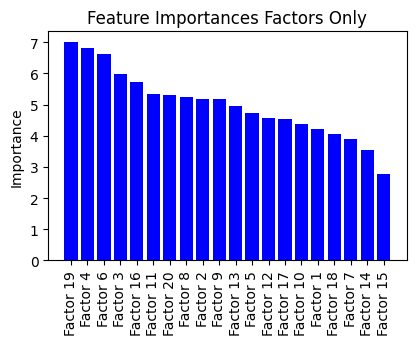

In [15]:
mofa_metrics = regression_pipeline_gdsc(mofa_factors, *pipeline_args)
m_f_mofa, r_f_mofa = mofa_metrics.values()

### MCCA

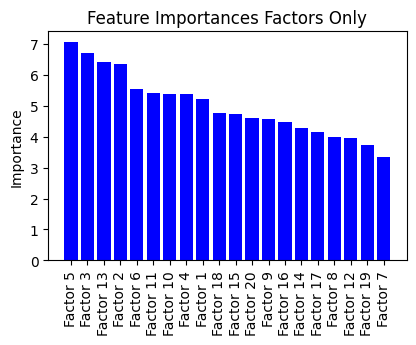

In [16]:
mcca_metrics = regression_pipeline_gdsc(mcca_factors, *pipeline_args)
m_f_mcca, r_f_mcca = mcca_metrics.values()

### PCA

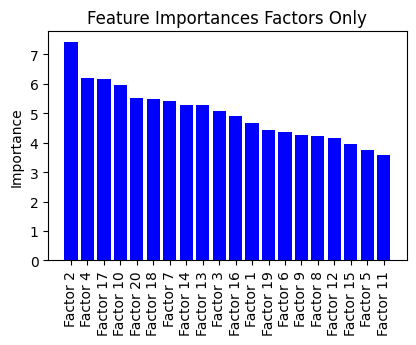

In [17]:
pca_metrics = regression_pipeline_gdsc(pca_factors, *pipeline_args)

m_f_pca, r_f_pca = pca_metrics.values()

### UMAP

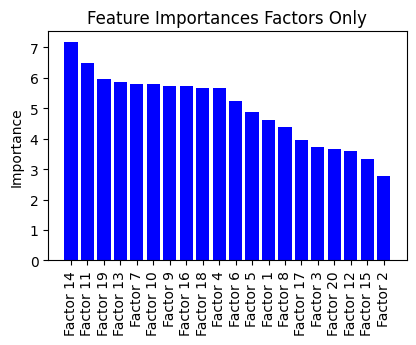

In [18]:
umap_metrics = regression_pipeline_gdsc(umap_factors, *pipeline_args)

m_f_umap, r_f_umap = umap_metrics.values()

### Base Autoencoder

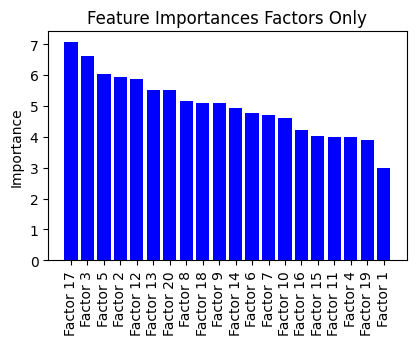

In [19]:
base_auto_metrics = regression_pipeline_gdsc(base_autoenc_factors, *pipeline_args)

m_f_base_auto, r_f_base_auto = base_auto_metrics.values()

### Triple Autoencoder

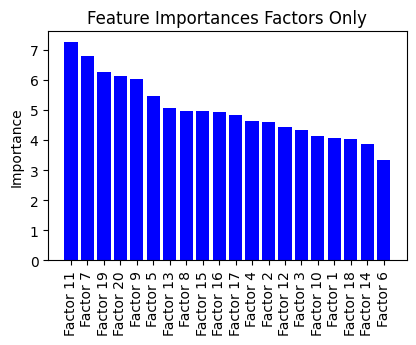

In [20]:
triple_auto_metrics = regression_pipeline_gdsc(triple_autoenc_factors, *pipeline_args)

m_f_triple_auto, r_f_triple_auto = triple_auto_metrics.values()

### Регрессия, результаты:

In [21]:
regr_results = pd.DataFrame({
    'MAPE factors, %': [m_f_base, m_f_pca, m_f_umap, m_f_mofa, m_f_mcca, m_f_base_auto, m_f_triple_auto],
    'RMSE factors, %': [r_f_base, r_f_pca, r_f_umap, r_f_mofa, r_f_mcca, r_f_base_auto, r_f_triple_auto],
}, index=['No factorization', 'PCA', 'UMAP', 'MOFA', 'MCCA', 'Base Autoencoder', 'Triple Autoencoder'])

regr_results['Method Average'] = regr_results.mean(axis=1)
column_means = regr_results.iloc[:, :-1].mean(axis=0)
regr_results.loc['All Methods Average'] = column_means.tolist() + ['-']

regr_results

,"MAPE factors, %","RMSE factors, %",Method Average
No factorization,49.217514,0.994070,25.105792
PCA,51.088908,1.067552,26.07823
UMAP,51.084223,1.050762,26.067492
MOFA,49.422188,1.034213,25.228201
MCCA,56.670819,1.163927,28.917373
Base Autoencoder,53.225613,1.089312,27.157462
Triple Autoencoder,56.039775,1.162882,28.601328
All Methods Average,52.392720,1.080388,-


### *В задаче предсказания ic50 по факторам, используя CatboostRegressor, лучше всего оказалась MOFA*